# Setup the data for analysis

In [43]:
import pandas as pd
df = pd.read_csv('peptide-variant_expression_table.tsv', sep='\t')


## Dropping unmodified columns
unmod_cols = [col for col in df.columns if '_unmod' in col]
df = df.drop(columns=unmod_cols)

columns_to_not_consider = ['rowid', 'ccms_row_id', 'Variant', 'Variant ID', 'Unmod variant', 'Total', 'Proteins', 'Mass', 'Charge', 'Num Mods', 'All Mods', 'Is Decoy', 'Lorikeet input', 'Orig cluster FDR', 'Pep Prefix', 'Variant FDR', 'Peptidoform', 'Canonical proteins', 'Top protein', 'Top canonical protein', 'Top protein FDR', 'Top canonical protein FDR', 'Rep cluster task', 'Rep cluster user', 'Rep cluster index', 'Num tasks', 'Outlier groups', 'Outlier group ratio', 'Outlier groups- unmod', 'Outlier group ratio- unmod', 'Unmod_Variant', 'Total- Unmodified sequence', 'Variants- Unmodified sequence']


bt474_caki_cols = [col for col in df.columns if 'BT474' in col or 'CAKI' in col]

df = df.drop(columns=bt474_caki_cols)

C:\Users\Rajat\AppData\Local\Temp\ipykernel_24672\440495652.py:2: DtypeWarning: Columns (32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276

In [44]:
# Standardize drug-concentration column names to 'drug_concentration' format
import re
def standardize_col(col):
    match = re.match(r'_dyn_#([\w-]+)[ _-]?([\d]+nM|DMSO|PDPD)\.Tech replicate.*', col)
    if match:
        drug = match.group(1).replace('-', '').replace('_', '').replace('with', '').replace('in', '').lower()
        conc = match.group(2).lower()
        return f'{drug}_{conc}'
    return col
df.rename(columns={col: standardize_col(col) for col in df.columns}, inplace=True)

# Convert standardized drug_concentration columns to integer (if possible)
for col in df.columns:
    if re.match(r'.+_(\d+nm|dmso|pdpd)$', col):
        df[col] = pd.to_numeric(df[col].str.replace(',', ''), errors='coerce').astype('Int64')

In [45]:
# Analyse NaN values in the dataframe
nan_counts = df.isna().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)
print('Columns with NaN values:')
print(nan_counts)
print(f'Number of columns with NaNs: {len(nan_counts)}')
print(f'Total NaN values in dataframe: {df.isna().sum().sum()}')

Columns with NaN values:
Peptidoform              83706
bi2536_30nm              83674
amg900_1000nm            83672
azd5438_30nm             83620
azd5438_100nm            83619
                         ...  
All Mods                 49397
Unmod_Variant            33047
Top canonical protein      863
Canonical proteins         863
Pep Prefix                 286
Length: 436, dtype: int64
Number of columns with NaNs: 436
Total NaN values in dataframe: 33726457


In [46]:
# Analyse NaN values at the row level
row_nan_counts = df.isna().sum(axis=1)
print('Rows with the most NaN values:')
print(row_nan_counts.value_counts().sort_index(ascending=False).head(10))
print(f'Maximum NaNs in a row: {row_nan_counts.max()}')
print(f'Rows with any NaNs: {(row_nan_counts > 0).sum()}')
print(f'Rows with all NaNs: {(row_nan_counts == len(df.columns)).sum()}')

Rows with the most NaN values:
436        1
435       88
434      488
433     5042
432    32298
431     6749
430     4149
429     2574
428     1974
427     1664
Name: count, dtype: int64
Maximum NaNs in a row: 436
Rows with any NaNs: 83706
Rows with all NaNs: 0


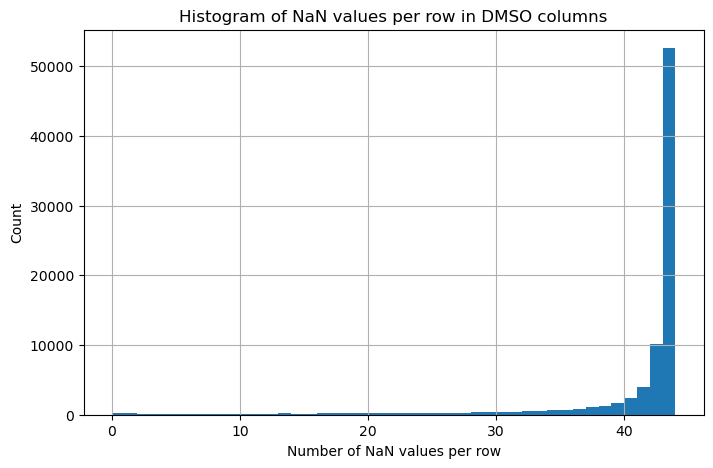

In [47]:
dmso_cols = [col for col in df.columns if "dmso" in col.lower()]
dmso_df = df[["Variant", "Unmod variant"] + dmso_cols].copy()
dmso_df["median"] = dmso_df[dmso_cols].median(axis=1, numeric_only=True)
dmso_df["n_nan"] = dmso_df[dmso_cols].isna().sum(axis=1)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
dmso_df["n_nan"].hist(bins=range(dmso_df["n_nan"].min(), dmso_df["n_nan"].max() + 2))
plt.xlabel("Number of NaN values per row")
plt.ylabel("Count")
plt.title("Histogram of NaN values per row in DMSO columns")
plt.show()

,Variant,Unmod variant,aew541_dmso,amg208_dmso,amg900_dmso,arry380_dmso,asp3026_dmso,at13148_dmso,at7519_dmso,at9283_dmso,...,bms754807_dmso,bms777607_dmso,bms911543_dmso,byl719_dmso,bafetib_dmso,barasertib_dmso,barasertibhqpa_dmso,baricitib_dmso,median,n_nan
1,.VADPDHDHTGFLTEYVATR.,.VADPDHDHTGFLTEYVATR.,152100000,78410000,21420000,473840000,51643000,658920000,346590000,348130000,...,50411000,30902000,103200000,21331000,86810000,354350000,402680000,254860000,132350000.0,0
2,.LGEHNIDVLEGNEQFINAAK.,.LGEHNIDVLEGNEQFINAAK.,274810000,80854000,17991000,620060000,199960000,107540000,95130000,50209000,...,131010000,127320000,153070000,71505000,28100000,459410000,593480000,313290000,153070000.0,0
3,.FRHENIIGINDIIR.,.FRHENIIGINDIIR.,434810000,6801700,24216000,233920000,66493000,628480000,202610000,269980000,...,123170000,53737000,205450000,72418000,191580000,183070000,280180000,236530000,151240000.0,0
4,.ESESTAGSFSLSVR.,.ESESTAGSFSLSVR.,24221000,5666100,982210,26512000,5997600,<NA>,1982300,13163000,...,4082700,3718100,13653000,7661200,5055800,5646500,5269500,12835000,5292500.0,2
5,.NYLLSLPHK.,.NYLLSLPHK.,845290000,316450000,41978000,465400000,209830000,734640000,176030000,311820000,...,230980000,119280000,600380000,167920000,408720000,237270000,247540000,43697000,220800000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6825,.IDGATQSSPAEPK.,.IDGATQSSPAEPK.,184940,957660,<NA>,619230,<NA>,10369000,380400,692070,...,702230,533550,1111300,<NA>,<NA>,477360,546970,1983200,628390.0,13
6848,.LYRPPPVLDALGR.,.LYRPPPVLDALGR.,3081600,1672800,<NA>,<NA>,701960,17568000,939360,2163200,...,<NA>,1116000,3451600,<NA>,1007000,<NA>,<NA>,2760200,1562500.0,11
6923,.YPVNSVNILK.,.YPVNSVNILK.,<NA>,<NA>,1170800,15837000,2734600,172190000,<NA>,5799000,...,<NA>,<NA>,<NA>,8233000,1712700,5548200,6507600,19894000,4190800.0,10
7058,.ELVSDANQHVK.,.ELVSDANQHVK.,366900,2201600,174870,<NA>,367270,2127400,811750,1472700,...,<NA>,<NA>,3413000,816810,385610,439280,597930,<NA>,814280.0,13


In [61]:
import plotly.graph_objects as go
import numpy as np

# Filter rows with less than 13 NaNs
filtered = dmso_df[dmso_df["n_nan"] < 13]
if not filtered.empty:
    row = filtered.sample(1).iloc[0]
    dmso_vals = row[dmso_cols]
    variant_name = row["Variant"]
    median_val = row["median"]

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=dmso_cols,
        y=dmso_vals.values,
        name="DMSO Levels"
    ))
    fig.add_hline(y=median_val, line_color="red", line_dash="dash", annotation_text="Median", annotation_position="top right")
    fig.update_layout(
        title=f"DMSO Levels for Variant: {variant_name}",
        xaxis_title="DMSO Columns",
        yaxis_title="Intensity",
        showlegend=False,
        height=400
    )
    fig.show()

    print(f"Variant: {variant_name}")

Variant: .TSSDPTC+57.021VEKEK.
